In [13]:
import pandas as pd
import numpy as np
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from collections import Counter
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import nltk

In [14]:
nltk.download("stopwords")
nltk.download("wordnet")
nltk.download("omw-1.4")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\dell\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\dell\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\dell\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [26]:
train = pd.read_table("../datasets/CREMA-D/text/train.txt", delimiter=";", header=None)
val = pd.read_table("../datasets/CREMA-D/text/val.txt", delimiter=";", header=None)
test = pd.read_table("../datasets/CREMA-D/text/test.txt", delimiter=";", header=None)

In [61]:
# Check the structure of the datasets
print(train.head())
print("Train Columns:", train.shape[1])  # Number of columns in the train dataset


                                                Text  Emotion  text_length
0                            i didnt feel humiliated  sadness            4
1  i can go from feeling so hopeless to so damned...  sadness           21
2   im grabbing a minute to post i feel greedy wrong    anger           10
3  i am ever feeling nostalgic about the fireplac...     love           18
4                               i am feeling grouchy    anger            4
Train Columns: 3


In [15]:

def load_datasets():
    train = pd.read_table("../datasets/CREMA-D/text/train.txt", delimiter=";", header=None)
    val = pd.read_table("../datasets/CREMA-D/text/val.txt", delimiter=";", header=None)
    test = pd.read_table("../datasets/CREMA-D/text/test.txt", delimiter=";", header=None)

    train.columns = ["Text", "Emotion"]
    val.columns = ["Text", "Emotion"]
    test.columns = ["Text", "Emotion"]

    return train, val, test


In [23]:
# Display basic information about the datasets
print("Train Dataset Shape:", train.shape)
print("Validation Dataset Shape:", val.shape)
print("Test Dataset Shape:", test.shape)

# Display the first few rows of the train dataset
print(train.head())


Train Dataset Shape: (16000, 4)
Validation Dataset Shape: (2000, 4)
Test Dataset Shape: (2000, 4)
                                                Text  Emotion  \
0                            i didnt feel humiliated  sadness   
1  i can go from feeling so hopeless to so damned...  sadness   
2   im grabbing a minute to post i feel greedy wrong    anger   
3  i am ever feeling nostalgic about the fireplac...     love   
4                               i am feeling grouchy    anger   

                                                text  N_label  
0                              didnt feel humiliated        4  
1  go feeling hopeless damned hopeful around some...        4  
2          im grabbing minute post feel greedy wrong        0  
3  ever feeling nostalgic fireplace know still pr...        3  
4                                    feeling grouchy        0  


In [24]:
# Check for null values
print("Train Missing Values:\n", train.isnull().sum())
print("Validation Missing Values:\n", val.isnull().sum())
print("Test Missing Values:\n", test.isnull().sum())


Train Missing Values:
 Text       0
Emotion    0
text       0
N_label    0
dtype: int64
Validation Missing Values:
 Text       0
Emotion    0
text       0
N_label    0
dtype: int64
Test Missing Values:
 Text       0
Emotion    0
text       0
N_label    0
dtype: int64


In [25]:
# Analyze class distribution
print("Train Class Distribution:\n", train['Emotion'].value_counts())
print("Validation Class Distribution:\n", val['Emotion'].value_counts())
print("Test Class Distribution:\n", test['Emotion'].value_counts())


Train Class Distribution:
 Emotion
joy         5362
sadness     4666
anger       2159
fear        1937
love        1304
surprise     572
Name: count, dtype: int64
Validation Class Distribution:
 Emotion
joy         704
sadness     550
anger       275
fear        212
love        178
surprise     81
Name: count, dtype: int64
Test Class Distribution:
 Emotion
joy         695
sadness     581
anger       275
fear        224
love        159
surprise     66
Name: count, dtype: int64


In [16]:

def preprocess_data(train, val, test):
    lemmatizer = WordNetLemmatizer()

    def preprocess_with_lemmatization(line):
        review = re.sub("[^a-zA-Z]", " ", line)
        review = review.lower()
        review = review.split()
        review = [lemmatizer.lemmatize(word) for word in review if word not in stopwords.words("english")]
        return " ".join(review)

    train["text"] = train["Text"].apply(preprocess_with_lemmatization)
    val["text"] = val["Text"].apply(preprocess_with_lemmatization)
    test["text"] = test["Text"].apply(preprocess_with_lemmatization)

    all_text = " ".join(train["text"].tolist() + val["text"].tolist() + test["text"].tolist())
    word_freq = Counter(all_text.split())
    threshold = 2

    train["text"] = train["text"].apply(lambda x: " ".join([word for word in x.split() if word_freq[word] >= threshold]))
    val["text"] = val["text"].apply(lambda x: " ".join([word for word in x.split() if word_freq[word] >= threshold]))
    test["text"] = test["text"].apply(lambda x: " ".join([word for word in x.split() if word_freq[word] >= threshold]))

    return train, val, test


In [17]:

def encode_labels(train, val, test):
    label_encoder = LabelEncoder()
    train["N_label"] = label_encoder.fit_transform(train["Emotion"])
    val["N_label"] = label_encoder.transform(val["Emotion"])
    test["N_label"] = label_encoder.transform(test["Emotion"])

    return train, val, test, label_encoder

In [18]:
def load_glove_embeddings(file_path):
    embedding_index = {}
    with open(file_path, "r", encoding="utf-8") as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype="float32")
            embedding_index[word] = coefs
    return embedding_index


In [19]:

def prepare_data_and_embeddings(train, val, test, embedding_index, max_len=100, vocab_size=5000, embedding_dim=100):
    tokenizer = Tokenizer(num_words=vocab_size)
    tokenizer.fit_on_texts(train["text"])

    X_train = tokenizer.texts_to_sequences(train["text"])
    X_val = tokenizer.texts_to_sequences(val["text"])
    X_test = tokenizer.texts_to_sequences(test["text"])

    X_train = pad_sequences(X_train, maxlen=max_len, padding="post")
    X_val = pad_sequences(X_val, maxlen=max_len, padding="post")
    X_test = pad_sequences(X_test, maxlen=max_len, padding="post")

    y_train = np.array(train["N_label"])
    y_val = np.array(val["N_label"])
    y_test = np.array(test["N_label"])

    word_index = tokenizer.word_index
    embedding_matrix = np.zeros((vocab_size, embedding_dim))
    for word, i in word_index.items():
        if i < vocab_size:
            embedding_vector = embedding_index.get(word)
            if embedding_vector is not None:
                embedding_matrix[i] = embedding_vector

    return X_train, X_val, X_test, y_train, y_val, y_test, embedding_matrix


In [20]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, Dropout, Dense, Flatten, BatchNormalization, GlobalMaxPooling1D
from tensorflow.keras.regularizers import l2

def build_and_compile_model(vocab_size, embedding_dim, max_len, embedding_matrix, num_classes):
    model = Sequential()

    # Embedding layer
    model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, weights=[embedding_matrix], input_length=max_len, trainable=False))

    # Convolutional layers
    model.add(Conv1D(256, kernel_size=3, activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(0.4))

    model.add(Conv1D(128, kernel_size=5, activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(0.4))

    # Fully connected layers
    model.add(GlobalMaxPooling1D())  # Global max pooling
    model.add(Dense(128, activation='relu', kernel_regularizer=l2(0.01)))  # Increase number of units and add L2 regularization
    model.add(Dropout(0.4))
    model.add(Dense(num_classes, activation='softmax'))

    # Compile the model
    model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"]) 

    return model


In [21]:

def train_and_evaluate_model(model, X_train, y_train, X_val, y_val, X_test, y_test, label_encoder):
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=10,
        batch_size=32,
        verbose=1
    )

    y_pred = np.argmax(model.predict(X_test), axis=1)
    cm = confusion_matrix(y_test, y_pred)
    cm_df = pd.DataFrame(cm, index=label_encoder.classes_, columns=label_encoder.classes_)

    plt.figure(figsize=(12, 8))
    sns.heatmap(cm_df, annot=True, cmap="Blues", fmt="d", cbar=False)
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

    test_loss, test_accuracy = model.evaluate(X_test, y_test)
    print(f"Test Accuracy: {test_accuracy * 100:.2f}%")


Epoch 1/10
500/500 [==============================] - 23s 42ms/step - loss: 3.0151 - accuracy: 0.3497 - val_loss: 2.3308 - val_accuracy: 0.4545
Epoch 2/10
500/500 [==============================] - 21s 42ms/step - loss: 1.9226 - accuracy: 0.5078 - val_loss: 1.5763 - val_accuracy: 0.6015
Epoch 3/10
500/500 [==============================] - 18s 37ms/step - loss: 1.4163 - accuracy: 0.5918 - val_loss: 1.0751 - val_accuracy: 0.7055
Epoch 4/10
500/500 [==============================] - 19s 38ms/step - loss: 1.0355 - accuracy: 0.6868 - val_loss: 0.7065 - val_accuracy: 0.7875
Epoch 5/10
500/500 [==============================] - 18s 36ms/step - loss: 0.7860 - accuracy: 0.7568 - val_loss: 0.5718 - val_accuracy: 0.8210
Epoch 6/10
500/500 [==============================] - 18s 36ms/step - loss: 0.6552 - accuracy: 0.7982 - val_loss: 0.4511 - val_accuracy: 0.8640
Epoch 7/10
500/500 [==============================] - 19s 38ms/step - loss: 0.5552 - accuracy: 0.8260 - val_loss: 0.4212 - val_accuracy:

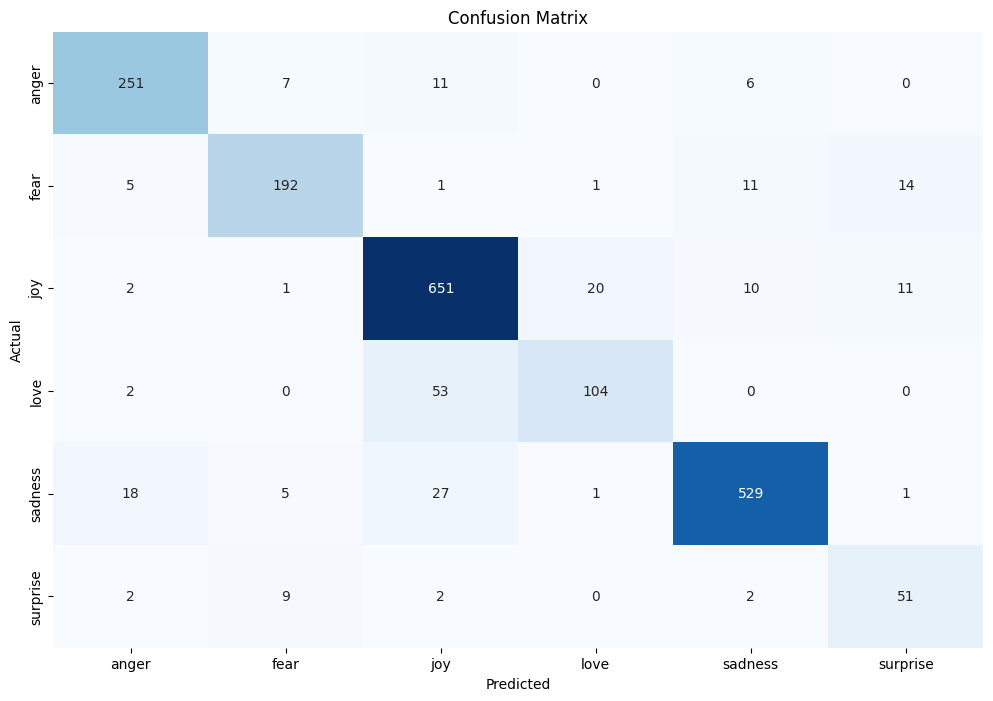

              precision    recall  f1-score   support

       anger       0.90      0.91      0.90       275
        fear       0.90      0.86      0.88       224
         joy       0.87      0.94      0.90       695
        love       0.83      0.65      0.73       159
     sadness       0.95      0.91      0.93       581
    surprise       0.66      0.77      0.71        66

    accuracy                           0.89      2000
   macro avg       0.85      0.84      0.84      2000
weighted avg       0.89      0.89      0.89      2000

63/63 [==============================] - 1s 9ms/step - loss: 0.3297 - accuracy: 0.8890
Test Accuracy: 88.90%


In [22]:
if __name__ == "__main__":
    # Load and preprocess datasets
    train, val, test = load_datasets()
    train, val, test = preprocess_data(train, val, test)
    train, val, test, label_encoder = encode_labels(train, val, test)

    # Load GloVe embeddings
    embedding_index = load_glove_embeddings("../datasets/glove.6B.100d.txt")


    # Prepare data and embeddings
    max_len = 100
    vocab_size = 5000
    embedding_dim = 100

    X_train, X_val, X_test, y_train, y_val, y_test, embedding_matrix = prepare_data_and_embeddings(
        train, val, test, embedding_index, max_len=max_len, vocab_size=vocab_size, embedding_dim=embedding_dim
    )

    # Build and compile the model
    model = build_and_compile_model(vocab_size, embedding_dim, max_len, embedding_matrix, len(label_encoder.classes_))

    # Train and evaluate the model
    train_and_evaluate_model(model, X_train, y_train, X_val, y_val, X_test, y_test, label_encoder)


In [50]:
traindata = pd.read_table("../datasets/CREMA-D/text/train.txt", delimiter=";", header=None)
valdata = pd.read_table("../datasets/CREMA-D/text/val.txt", delimiter=";", header=None)
testdata = pd.read_table("../datasets/CREMA-D/text/test.txt", delimiter=";", header=None)

In [51]:
traindata.columns = ["Text", "Label"]
valdata.columns = ["Text", "Label"]
testdata.columns = ["Text", "Label"]


In [53]:
# Compute text length for each dataset
traindata["text_length"] = traindata["Text"].apply(lambda x: len(x.split()))
valdata["text_length"] = valdata["Text"].apply(lambda x: len(x.split()))
testdata["text_length"] = testdata["Text"].apply(lambda x: len(x.split()))

# Summary statistics for text lengths
print("Train Text Length:\n", traindata["text_length"].describe())
print("Validation Text Length:\n", valdata["text_length"].describe())
print("Test Text Length:\n", testdata["text_length"].describe())


Train Text Length:
 count    16000.000000
mean        19.166313
std         10.986905
min          2.000000
25%         11.000000
50%         17.000000
75%         25.000000
max         66.000000
Name: text_length, dtype: float64
Validation Text Length:
 count    2000.000000
mean       18.866000
std        10.813025
min         2.000000
25%        10.000000
50%        17.000000
75%        25.000000
max        61.000000
Name: text_length, dtype: float64
Test Text Length:
 count    2000.000000
mean       19.154000
std        11.012353
min         3.000000
25%        10.000000
50%        17.000000
75%        26.000000
max        61.000000
Name: text_length, dtype: float64


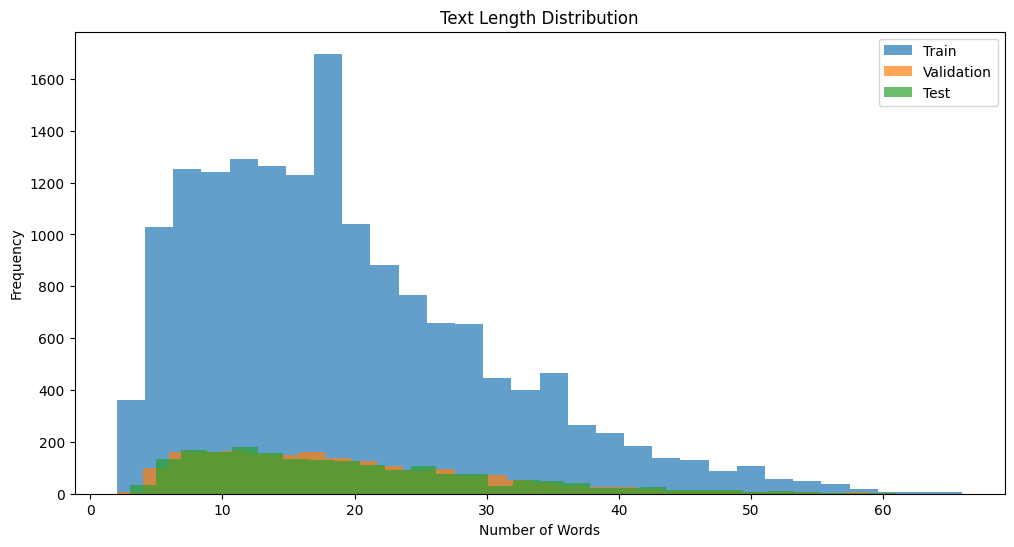

In [54]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.hist(traindata["text_length"], bins=30, alpha=0.7, label="Train")
plt.hist(valdata["text_length"], bins=30, alpha=0.7, label="Validation")
plt.hist(testdata["text_length"], bins=30, alpha=0.7, label="Test")
plt.xlabel("Number of Words")
plt.ylabel("Frequency")
plt.title("Text Length Distribution")
plt.legend()
plt.show()


In [55]:
# Define thresholds for outliers
min_threshold = traindata["text_length"].quantile(0.05)  # Lower 5%
max_threshold = traindata["text_length"].quantile(0.95)  # Upper 5%

# Identify outliers
train_outliers = traindata[(traindata["text_length"] < min_threshold) | (traindata["text_length"] > max_threshold)]
print("Train Outliers based on text length:\n", train_outliers)

val_outliers = valdata[(valdata["text_length"] < min_threshold) | (valdata["text_length"] > max_threshold)]
print("Validation Outliers based on text length:\n", val_outliers)

test_outliers = testdata[(testdata["text_length"] < min_threshold) | (testdata["text_length"] > max_threshold)]
print("Test Outliers based on text length:\n", test_outliers)


Train Outliers based on text length:
                                                     Text     Label  \
0                                i didnt feel humiliated   sadness   
4                                   i am feeling grouchy     anger   
9                                    i feel romantic too      love   
14     i have immense sympathy with the general point...       joy   
21     i am feeling completely overwhelmed i have two...      fear   
...                                                  ...       ...   
15887  i guess this isnt a very exciting story but it...   sadness   
15941  i get the feeling that i m totally isolated fr...   sadness   
15976                             i didnt feel exhausted   sadness   
15979  i have writer s block or feel too apprehensive...      fear   
15989  i need to do this that and the other for colle...  surprise   

       text_length  
0                4  
4                4  
9                4  
14              42  
21              

In [56]:
# Analyze label distributions
print("Train Label Distribution:\n", traindata["Label"].value_counts())
print("Validation Label Distribution:\n", valdata["Label"].value_counts())
print("Test Label Distribution:\n", testdata["Label"].value_counts())


Train Label Distribution:
 Label
joy         5362
sadness     4666
anger       2159
fear        1937
love        1304
surprise     572
Name: count, dtype: int64
Validation Label Distribution:
 Label
joy         704
sadness     550
anger       275
fear        212
love        178
surprise     81
Name: count, dtype: int64
Test Label Distribution:
 Label
joy         695
sadness     581
anger       275
fear        224
love        159
surprise     66
Name: count, dtype: int64


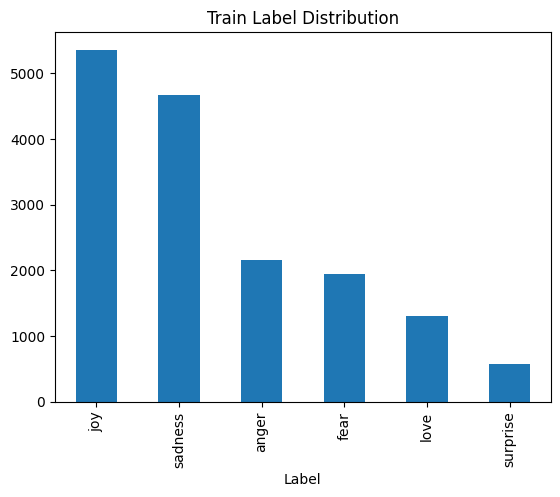

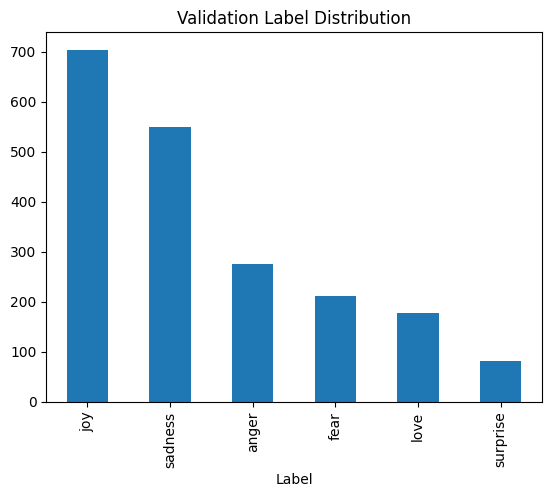

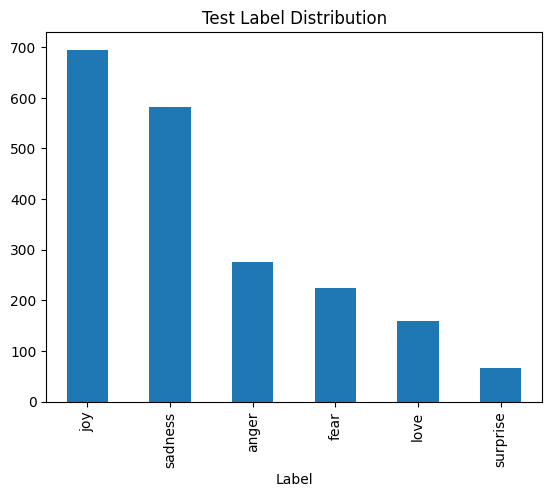

In [57]:
traindata["Label"].value_counts().plot(kind="bar", title="Train Label Distribution")
plt.show()

valdata["Label"].value_counts().plot(kind="bar", title="Validation Label Distribution")
plt.show()

testdata["Label"].value_counts().plot(kind="bar", title="Test Label Distribution")
plt.show()


In [58]:
# Check for duplicates
train_duplicates = traindata[traindata.duplicated(subset=["Text"], keep=False)]
print("Duplicate Texts in Train Data:\n", train_duplicates)

val_duplicates = valdata[valdata.duplicated(subset=["Text"], keep=False)]
print("Duplicate Texts in Validation Data:\n", val_duplicates)

test_duplicates = testdata[testdata.duplicated(subset=["Text"], keep=False)]
print("Duplicate Texts in Test Data:\n", test_duplicates)


Duplicate Texts in Train Data:
                                                     Text    Label  text_length
364    i tend to stop breathing when i m feeling stre...  sadness           10
1501   i feel on the verge of tears from weariness i ...     love           23
1625   i was intensely conscious of how much cash i h...    anger           38
1802                    i still feel completely accepted      joy            5
2908   im still not sure why reilly feels the need to...     fear           13
...                                                  ...      ...          ...
15315  i will feel as though i am accepted by as well...      joy           20
15329  i shy away from songs that talk about how i fe...      joy           24
15572  i bet taylor swift basks in the knowledge that...    anger           18
15705  i began to feel accepted by gaia on her own terms      joy           11
15876  i was sitting in the corner stewing in my own ...    anger           17

[62 rows x 3 column

In [59]:
# Empty texts
train_empty = traindata[traindata["Text"].str.strip() == ""]
print("Empty Texts in Train Data:\n", train_empty)

# Very short texts
train_very_short = traindata[traindata["text_length"] < 3]  # Texts with fewer than 3 words
print("Very Short Texts in Train Data:\n", train_very_short)


Empty Texts in Train Data:
 Empty DataFrame
Columns: [Text, Label, text_length]
Index: []
Very Short Texts in Train Data:
                   Text    Label  text_length
4150       earth crake     fear            2
4997   during lectures      joy            2
8824         in sweden     fear            2
9355       no response    anger            2
12204        one night      joy            2
12546        at school    anger            2
12801          one day  sadness            2
13316   no description    anger            2


In [60]:
# Texts with non-alphanumeric characters
train_non_standard = traindata[traindata["Text"].str.contains(r"[^a-zA-Z0-9.,!?\\s]")]
print("Texts with Non-standard Characters in Train Data:\n", train_non_standard)


Texts with Non-standard Characters in Train Data:
                                                     Text    Label  text_length
0                                i didnt feel humiliated  sadness            4
1      i can go from feeling so hopeless to so damned...  sadness           21
2       im grabbing a minute to post i feel greedy wrong    anger           10
3      i am ever feeling nostalgic about the fireplac...     love           18
4                                   i am feeling grouchy    anger            4
...                                                  ...      ...          ...
15995  i just had a very brief time in the beanbag an...  sadness           24
15996  i am now turning and i feel pathetic that i am...  sadness           20
15997                     i feel strong and good overall      joy            6
15998  i feel like this was such a rude comment and i...    anger           14
15999  i know a lot but i feel so stupid because i ca...  sadness           15

